# Table of Contents

* [Introduction](#Introduction)
* [Analysis](#Analysis)
* [Report](#Report)

# Introduction

Author: Alan Lorenzetti  
Date: 02/01/2023 

In this analysis, I plotted SVA five prime profile and coverage for reads coming from PacBio Iso-Seq of brain samples. Only the reads starting within the region of SVAs' start sites plus flanking regions were considered in this round of analysis. The data was gathered from ENCODE and represent all the brain samples one could acquire up to the moment.

# Analysis

This script will take the coverage matrices generated by deeptools software. It is going to organize the data into tidy tibbles and then will plot data using ggplot.

In [1]:
# 20220918 alorenzetti

# description ####
# This script will take the coverage
# matrices generated by deeptools software.
# It is going to organize the data into
# tidy tibbles and then will plot data using ggplot.  

# setting up ####
# loading libs
packs = c(
 "tidyverse",
 "ggpubr",
 "ggthemes",
 "svglite",
 "viridis",
 "Biostrings",
 "BSgenome",
 "rtracklayer",
 "ggbeeswarm"
)

lapply(packs, require, character.only = TRUE)

theme_set(theme_pubr())

# setting working directory relative to _h
setwd("../_m/")

# setting up path
# matching the bin
# in the conda env
# this is necessary
# for R finding
# the trf program
conda_env = str_replace(Sys.getenv("R_HOME"), "^.*/(.*)/lib/R$", "\\1")
home = str_replace(Sys.getenv("R_HOME"), "^(.*)/.*/lib/R$", "\\1")
conda_env_path = paste0(home, "/", conda_env, "/bin")
old_path = Sys.getenv("PATH")
Sys.setenv(PATH = paste(old_path, conda_env_path, sep = ":"))

# adjusting tableau color scheme pal
tableau10_col_blind_bckp = ggthemes::ggthemes_data[["tableau"]][["color-palettes"]][["regular"]][["Color Blind"]]
tableau10_col_blind_mod = tableau10_col_blind_bckp
tableau10_col_blind_mod[1:10,] = tableau10_col_blind_bckp[c(7,9,3,4,5,10,8,1,2,6),]
# scales::show_col(tableau10_col_blind_mod$value)
# scales::show_col(tableau10_col_blind_bckp$value)

ggthemes_data[["tableau"]][["color-palettes"]][["regular"]][["Color Blind"]] = tableau10_col_blind_mod

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: ggpubr

Loading required package: ggthemes

Loading required package: svglite

Loading required package: viridis

Loading required package: viridisLite

Loading required package: Biostrings

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.fram

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

In [2]:
# getting started ####
# i gotta modify this function to allow a
# modified palette in ggthemes
# it is basecally changing where it gets the
# palettes from (see commented for original)
custom_tableau_color_pal = function (palette = "Tableau 10", type = c("regular", "ordered-sequential", 
    "ordered-diverging"), direction = 1) 
{
    type <- match.arg(type)
    # palettes <- ggthemes::ggthemes_data[["tableau"]][["color-palettes"]][[type]]
    palettes <- ggthemes_data[["tableau"]][["color-palettes"]][[type]]
    if (!palette %in% names(palettes)) {
        stop("`palette` must be one of ", paste(names(palettes), 
            collapse = ", "), ".")
    }
    values <- palettes[[palette]][["value"]]
    max_n <- length(values)
    f <- function(n) {
        check_pal_n(n, max_n)
        values <- values[seq_len(n)]
        if (direction < 0) {
            values <- rev(values)
        }
        values
    }
    attr(f, "max_n") <- length(values)
    f
}

environment(custom_tableau_color_pal) = asNamespace('ggthemes')
assignInNamespace("tableau_color_pal", custom_tableau_color_pal, ns = "ggthemes")

In [3]:
# this function will parse
# original matrices
read_cov_matrices = function(libname = libname,
                             covtype = covtype,
                             strand = strand,
                             orientation = orientation,
                             outputtype = outputtype) {
    
    filepath = paste0(libname, "_", covtype, "_", strand, "_", orientation, "_matrix.tsv")
    
    svapath = paste0("sva_", strand, ".bed")
    svacolnames = c("chr", "start", "end", "name", "score", "strand")
    sva_bed = read_tsv(file = svapath,
                       col_names = svacolnames,
                       show_col_types = F) %>% 
        mutate(start = start + 1) %>% 
        mutate(name = paste0(chr, ":", start, ":", end, ":", strand, ":", str_replace(name, pattern = "^.*:", replacement = "")))
    
    preM = read_tsv(file = filepath,
                    col_names = F,
                    skip = 3,
                    show_col_types = F, num_threads = round(parallel::detectCores()/2))
    
    ncol = dim(preM)[2]
    coords =  c(seq(-(ncol/2), -1, 1), seq(1, ncol/2))
    colnames(preM) = coords
    
    preM = preM %>%
        mutate(across(.cols = everything(),
                      .fns = ~ case_when(is.nan(.x) ~ NA_real_,
                                         TRUE ~ .x)))
    M = preM %>% 
        mutate(sample = libname,
               coverage_type = covtype,
               coverage_orientation = orientation,
               sva_strand = strand,
               sva_name = sva_bed$name,
               sva_type = sva_bed$name %>% str_replace(pattern = "^.*:", replacement = ""))
    
    if(outputtype == "cov_matrix"){
        return(M)
    }else if(outputtype == "tidy") {
        
        tidy_tibble = pivot_longer(data = M,
                                   cols = as.character(coords),
                                   names_to = "coordinate",
                                   values_to = "counts")
        
        write_tsv(x = tidy_tibble,
                  file = "full_tidy_tib.tsv",
                  append = T)
        
        tidy_tibble = tidy_tibble %>%
            group_by(sample,
                     coverage_type,
                     coordinate,
                     sva_strand,
                     coverage_orientation,
                     sva_type) %>% 
            summarise(counts = sum(counts, na.rm = T))
        
        return(tidy_tibble)
    }
}

In [4]:
# this function will
# iterate over variables
# to read matrices
iterate = function(samples = samples,
                   covtypes = covtypes,
                   strands = strands,
                   orientations = orientations,
                   outputtype = outputtype) {
    
    if(file.exists("full_tidy_tib.tsv")){
        file.remove("full_tidy_tib.tsv")
    }
    
    matrices = list()
    tidyobj = tibble()
    for(i in samples){
        for(j in covtypes){
            for(k in strands){
                for(l in orientations){
                    matrices[[i]][[j]][[k]][[l]] = read_cov_matrices(libname = i,
                                                                     covtype = j,
                                                                     strand = k,
                                                                     orientation = l,
                                                                     outputtype = outputtype)
                    
                    tidyobj = bind_rows(tidyobj,
                                        matrices[[i]][[j]][[k]][[l]])
                }
            }
        }
    }
    
    return(tidyobj)
}

In [5]:
# this function will subset
# the dataframes and remove coordinates
# away from user defined regions
chop_coords = function(tib = tib,
                       left = left,
                       right = right){
    
    tib = tib %>% 
        filter(as.numeric(coordinate) >= left & 
              as.numeric(coordinate) <= right)
    
    return(tib)
}

In [6]:
# this function will read
# and parse metadata
parse_metadata = function(file = file,
                          alt_version = alt_version) {
    
    metadata = read_tsv(file) %>% 
        select(Accession,
               `Biosample summary`,
               `Biosample term name`,
               Description,
               `Biosample age`,
               `Biosample accession`,
               Files) %>% 
        separate_rows(Files, sep = ",") %>% 
        mutate(Files = str_replace(Files, "^/files/(.*)/$", "\\1")) %>% 
        mutate(sample_source = case_when(str_detect(`Biosample summary`, "astrocyte") ~ "astrocyte_cell_culture",
                                         str_detect(`Biosample summary`, "Alzheimer") ~ "alzheimers_disease_subject",
                                         TRUE ~ "control_subject"))
    
    if(alt_version == F){
        
        metadata = metadata %>% 
            select(Files, sample_source)
        
    } else {
        
        metadata = metadata %>% 
            dplyr::select(experiment_id = Accession,
                  biosample_id = `Biosample accession`,
                  file_id = Files,
                  biosample_description = `Biosample summary`,
                  source = Description,
                  age = `Biosample age`,
                  group_alias = sample_source) %>% 
            mutate(biosample_description = str_replace(biosample_description,
                                                       "^Homo sapiens ",
                                                       "")) %>% 
            mutate(biosample_description = str_replace(biosample_description,
                                                       " \\(.* years\\)$",
                                                       "")) %>% 
            mutate(biosample_description = ifelse(biosample_description == "astrocyte",
                                                  "astrocyte cell culture",
                                                  biosample_description)) %>% 
            mutate(doi = paste0("https://doi.org/10.17989/", experiment_id)) %>% 
            mutate(biosample_id = ifelse(file_id == "ENCFF672WCL", "ENCBS372XQF", biosample_id)) %>% 
            mutate(biosample_id = ifelse(file_id == "ENCFF011XVU", "ENCBS100HNS", biosample_id))
        
    }
    
    return(metadata)
}

In [7]:
# this function will
# make tile plots to
# see all SVAs at once
plot_tiles = function(data = data,
                      coverage_type = coverage_type,
                      coverage_orientation = coverage_orientation,
                      fill_lims = fill_lims) {
    
    coverage_t = coverage_type
    coverage_o = coverage_orientation
    
    filt_data = data %>%
        filter(coverage_type == coverage_t) %>% 
        filter(coverage_orientation == coverage_o) %>% 
        mutate(counts = case_when(is.na(counts) ~ 0,
                                  TRUE ~ counts)) %>% 
        group_by(sva_name, coordinate) %>% 
        summarise(counts = sum(counts))
    
    svaorder = filt_data %>% 
        group_by(sva_name) %>% 
        summarise(average = mean(counts),
                  sd = sd(counts)) %>% 
        arrange(average) %>% 
        pull(sva_name)
    
    yaxisorder = filt_data$coordinate %>%
        unique() %>% 
        as.numeric() %>% 
        .[order(.)] %>% 
        as.character()

    plot = filt_data %>% 
        ggplot(aes(x = factor(coordinate,
                              levels = yaxisorder),
                   y = factor(sva_name,
                              levels = svaorder),
                   fill = (counts + 1) %>% log10())) +
        geom_raster() +
        scale_fill_viridis(name = "Log10(counts + 1)",
                           limits = fill_lims) +
        scale_x_discrete(name = "Genome coordinate",
                         labels = labels) +
        ylab("SVA index") +
        theme_pubr() +
        theme(axis.ticks.x = element_blank(),
              axis.text.x = element_text(hjust=1,
                                         angle = 45),
              axis.text.y = element_blank(),
              legend.position = "bottom")
    
    return(plot)
}

In [8]:
# main code ####
# reading metadata
metadata = parse_metadata(file = "metadata.tsv", alt_version = F)
write_tsv(metadata, "parsed_metadata.tsv")

# getting variables to iterate over
samples = list.files(path = ".", pattern = "*_matrix.tsv") %>% 
    str_replace(pattern = "_.*$", replacement = "") %>% 
    unique()
# samples = samples[1]
covtypes = c("coverage", "5_prime_profile")
strands = c("forward", "reverse")
orientations = c("sense", "antisense")

# alternative metadata
# for the manuscript
metadata_manuscript = parse_metadata(file = "metadata.tsv",
                                     alt_version = T) %>% 
    filter(file_id %in% samples) %>% 
    filter(group_alias != "astrocyte_cell_culture") %>%
    arrange(desc(group_alias))
    
write_tsv(metadata_manuscript, "encode_files_metadata.tsv")

# reading files
tidy_tib = iterate(samples = samples,
                   covtypes = covtypes,
                   strands = strands,
                   orientations = orientations,
                   outputtype = "tidy")

# saving
write_tsv(x = tidy_tib,
          file = "tidy_tib.tsv")

###
# tidy_tib = read_tsv("tidy_tib.tsv")

# forward and reverse SVAs
# are gonna have the counts added up
# and antisense counts will get
# a minus value for plotting
tidy_tib_adj = tidy_tib %>% 
     group_by(sample,
              coverage_type,
              coordinate,
              coverage_orientation,
              sva_type) %>% 
     summarise(counts = sum(counts, na.rm = T)) %>% 
     ungroup() %>% 
     mutate(counts = case_when(coverage_orientation == "antisense" ~ counts * -1,
                               TRUE ~ counts)) %>% 
    left_join(x = .,
              y = metadata,
              by = c("sample" = "Files"))

# saving
write_tsv(x = tidy_tib_adj,
          file = "tidy_tib_adj.tsv")

###
# tidy_tib_adj = read_tsv("tidy_tib_adj.tsv")

Rows: 10 Columns: 39
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (16): ID, Accession, Assay name, Assay title, Biosample summary, Biosamp...
dbl  (1): Technical replicate
lgl (21): Target, Target of assay, Target gene symbol, Dbxrefs, Related seri...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10 Columns: 39
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (16): ID, Accession, Assay name, Assay title, Biosample summary, Biosamp...
dbl  (1): Technical replicate
lgl (21): Target, Target of assay, Target gene symbol, Dbxrefs, Related seri...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'sample', 'coverage_type', 'coordinate

In [9]:
# since we are gonna inspect
# counts relative to individual
# SVAs, we have to load the full
# tidy dataset saved by the 
# iterate + read_cov_matrices
# functions
colnames = c("sample", "coverage_type",
             "coverage_orientation", "strand",
             "sva_name",  "sva_type",
             "coordinate", "counts")

full_tidy_dataset = read_tsv("full_tidy_tib.tsv",
                             col_names = colnames,
                             num_threads = round(parallel::detectCores()/2))

# reading the SVA
# bed file
svacolnames = c("chr", "start", "end", "name", "score", "strand")
sva_bed = read_tsv(file = "sva.bed", col_names = svacolnames) %>% 
        mutate(start = start + 1) %>% 
        mutate(name = paste0(chr, ":", start, ":", end, ":", strand, ":", str_replace(name, pattern = "^.*:", replacement = "")))

# getting insights ####
insights = list()

insights$five_prime_profile$counts_per_sva = full_tidy_dataset %>%
    filter(coverage_type == "5_prime_profile") %>% 
    filter(coordinate >= 1) %>% 
    mutate(counts = as.numeric(counts)) %>% 
    mutate(counts = case_when(is.na(counts) ~ 0,
                              TRUE ~ counts)) %>% 
    group_by(sva_name) %>% 
    summarise(counts = sum(counts)) %>% 
    filter(counts != 0)

insights$five_prime_profile$within_sva = full_tidy_dataset %>% 
    filter(coverage_type == "5_prime_profile") %>% 
    filter(coordinate >= 1) %>% 
    mutate(counts = as.numeric(counts)) %>% 
    filter(!is.na(counts))

insights$five_prime_profile$flanking_sva_start = full_tidy_dataset %>% 
    filter(coverage_type == "5_prime_profile") %>% 
    mutate(counts = as.numeric(counts)) %>% 
    filter(!is.na(counts))

# writing counts
# info to use in the next script
write_tsv(x = insights$five_prime_profile$within_sva,
          file = "insights_fivePrimeProfile_withinSvaBegin.tsv")

write_tsv(x = insights$five_prime_profile$flanking_sva_start,
          file = "insights_fivePrimeProfile_flankingSvaStart.tsv")

insights$coverage$counts_per_sva = full_tidy_dataset %>%
    filter(coverage_type == "coverage") %>% 
    filter(coordinate >= 1) %>% 
    mutate(counts = as.numeric(counts)) %>% 
    mutate(counts = case_when(is.na(counts) ~ 0,
                              TRUE ~ counts)) %>% 
    group_by(sva_name) %>% 
    summarise(counts = sum(counts)) %>% 
    filter(counts != 0)

insights$coverage$max_per_sva = full_tidy_dataset %>%
    filter(coverage_type == "coverage") %>% 
    filter(coordinate >= 1) %>% 
    mutate(counts = as.numeric(counts)) %>% 
    mutate(counts = case_when(is.na(counts) ~ 0,
                              counts < 0 ~ counts * -1, 
                              TRUE ~ counts)) %>% 
    group_by(sva_name, coverage_orientation) %>% 
    summarise(counts = max(counts)) %>% 
    filter(counts != 0)

# writing max per sva
# info to use in the next script
write_tsv(x = insights$coverage$max_per_sva,
          file = "insights_coverage_maxpersva.tsv")

Rows: 189552000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): sample, coverage_type, coverage_orientation, strand, sva_name, sva_...
dbl (2): coordinate, counts

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2154 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, name, strand
dbl (3): start, end, score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'sva_name'. You can override using the
`.groups` argument.


In [10]:
# plotting ####
plots = list()

yaxis = tidy_tib_adj$coordinate %>%
    unique() %>% 
    as.numeric() %>% 
    .[order(.)] %>% 
    as.character()

labels = rep("", length(yaxis))
labels[which(yaxis == "1")] = "SVA start"
labels[which(as.numeric(yaxis) == min(as.numeric(yaxis)))] = as.character(min(as.numeric(yaxis)))
labels[which(as.numeric(yaxis) == max(as.numeric(yaxis)))] = as.character(max(as.numeric(yaxis)))

# five_prime_cov
plots_five_prime_cov_all = tidy_tib_adj %>%
    filter(coverage_type == "5_prime_profile") %>% 
    ggplot(aes(x = factor(coordinate, levels = yaxis),
               y = counts,
               fill = coverage_orientation)) +
    geom_col(show.legend = T, width = 1) +
    geom_vline(xintercept = "1", size = 0.5) +
    # geom_vline(xintercept = "72", linetype = 2, size = 0.5) +
    scale_x_discrete(name = "Coordinate",
                     labels = labels) +
    scale_y_continuous(name = "Coverage of long read 5' end",
                       labels = abs) +
    scale_fill_tableau(palette = "Color Blind",
                       name = "Transcript orientation",
                       labels = c("antisense" = "Antisense",
                                  "sense" = "Sense")) +
    theme_pubr() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust=1,
                                     angle = 45))

plots_five_prime_cov_by_sva = plots_five_prime_cov_all +
    facet_wrap(~ sva_type, scales = "free_y")

# regular cov
plots_coverage_all = tidy_tib_adj %>%
    filter(coverage_type == "coverage") %>% 
    ggplot(aes(x = factor(coordinate, levels = yaxis),
               y = counts,
               fill = coverage_orientation)) +
    geom_col(show.legend = F, width = 1) +
    geom_vline(xintercept = "1", size = 0.5) +
    # geom_vline(xintercept = "72", linetype = 2, size = 0.5) +
    scale_x_discrete(name = "Genome coordinate",
                     labels = labels) +
    scale_y_continuous(name = "Coverage",
                       labels = abs) +
    scale_fill_tableau(palette = "Color Blind") +
    theme_pubr() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust=1,
                                     angle = 45))

plots_coverage_by_sva = plots_coverage_all +
    facet_wrap(~ sva_type, scales = "free_y")

In [11]:
# BY SAMPLE TYPE
# five_prime_cov
plots_five_prime_cov_by_sample = tidy_tib_adj %>%
    filter(coverage_type == "5_prime_profile") %>% 
    ggplot(aes(x = factor(coordinate, levels = yaxis),
               y = counts,
               fill = coverage_orientation)) +
    geom_col(width = 1) +
    geom_vline(xintercept = "1", size = 0.5) +
    # geom_vline(xintercept = "72", linetype = 2, size = 0.5) +
    facet_wrap(~ factor(x = sample_source,
                        levels = c("alzheimers_disease_subject",
                                   "control_subject",
                                   "astrocyte_cell_culture"),
                        labels = c("Alzheimer's Disease",
                                   "Control",
                                   "Astrocyte cell culture")),
               ncol = 1,
               scale = "free_y") +
    scale_x_discrete(name = "Genome coordinate",
                     labels = labels) +
    scale_y_continuous(name = "Read start coverage",
                       labels = abs) +
    scale_fill_tableau(palette = "Color Blind",
                       name = "Transcript orientation",
                       labels = c("antisense" = "Antisense",
                                  "sense" = "Sense")) +
    theme_pubr() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust=1,
                                     angle = 45))

# regular cov
plots_coverage_by_sample = tidy_tib_adj %>%
    filter(coverage_type == "coverage") %>% 
    ggplot(aes(x = factor(coordinate, levels = yaxis),
               y = counts,
               fill = coverage_orientation)) +
    geom_col(show.legend = F, width = 1) +
    geom_vline(xintercept = "1", size = 0.5) +
    # geom_vline(xintercept = "72", linetype = 2, size = 0.5) +
    facet_wrap(~ factor(x = sample_source,
                        levels = c("alzheimers_disease_subject",
                                   "control_subject",
                                   "astrocyte_cell_culture"),
                        labels = c("Alzheimer's Disease",
                                   "Control",
                                   "Astrocyte cell culture")),
               ncol = 1,
               scale = "free_y") +
    scale_x_discrete(name = "Genome coordinate",
                     labels = labels) +
    scale_y_continuous(name = "Coverage",
                       labels = abs) +
    scale_fill_tableau(palette = "Color Blind") +
    theme_pubr() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust=1,
                                     angle = 45))

In [12]:
# plotting tiles ####
plots_five_prime_cov_tiles_sense = plot_tiles(data = full_tidy_dataset,
                                              coverage_type = "5_prime_profile",
                                              coverage_orientation = "sense",
                                              fill_lims = c(0,0.5))

plots_five_prime_cov_tiles_antisense = plot_tiles(data = full_tidy_dataset,
                                                  coverage_type = "5_prime_profile",
                                                  coverage_orientation = "antisense",
                                                  fill_lims = c(0,0.5))

plots_coverage_tiles_sense = plot_tiles(data = full_tidy_dataset,
                                        coverage_type = "coverage",
                                        coverage_orientation = "sense",
                                        fill_lims = c(0,2))

plots_coverage_tiles_antisense = plot_tiles(data = full_tidy_dataset,
                                            coverage_type = "coverage",
                                            coverage_orientation = "antisense",
                                            fill_lims = c(0,2))

`summarise()` has grouped output by 'sva_name'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'sva_name'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'sva_name'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'sva_name'. You can override using the
`.groups` argument.


In [13]:
# arranging a panel for each
plots_five_prime_cov_tiles_panel = ggarrange(plotlist = list(plots_five_prime_cov_tiles_sense,
                                                             plots_five_prime_cov_tiles_antisense),
                                             nrow = 1, ncol = 2,
                                             labels = "AUTO")

plots_coverage_tiles_panel = ggarrange(plotlist = list(plots_coverage_tiles_sense,
                                                       plots_coverage_tiles_antisense),
                                       nrow = 1, ncol = 2,
                                       labels = "AUTO")

# Report

In brief, I centered panels on the SVA start position, with 1 kb flanking regions, and checked: i) the cumulative five prime profiles (Fig. 1AB), that is, the coverage of the first base of reads, which could be a proxy for transcription start sites; ii) and the cumulative per-base read coverage for reads starting with the depicted region (aka single nucleotide read depth; Fig. 2AB). I did that for bulk SVAs (all the ~2k SVAs longer than 1 kb (vanBree/Jacobs et al. 2022)) and for separate SVAs. I collapsed all 11 samples (including two astrocyte samples, four control subjects, and five Alzheimer's disease subjects).  

The results seem exciting to me, especially Fig. 1A, which depicts a putative antisense transcription start site within the hexamer region (see a peak in-between the solid and the dashed lines). When analyzing SVAs separately (Fig. 1B), SVA D seem to be the greatest contributor to this putative antisense transcription start site.  

Considering the general coverage (Fig. 2AB), SVAs show a higher coverage on the plus strand relative to the negative strand (Fig. 2A). That is also true for separate SVAs (Fig. 2B). 

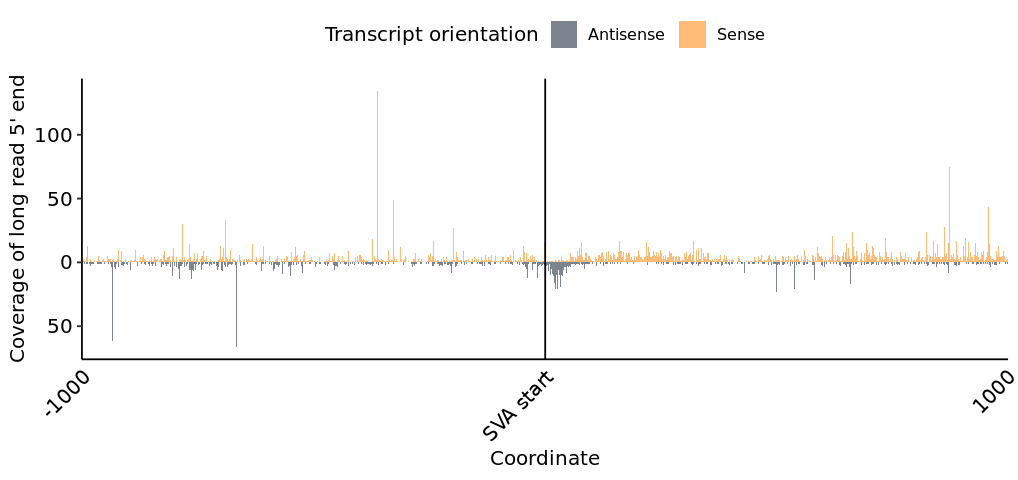

In [14]:
options(repr.plot.width = 8.49, repr.plot.height = 4)
plots_five_prime_cov_all

Fig. 1A. 5' profile (read start coverage) for all SVAs across multiple samples. Orange and blue bars depict the coverage of the positive and negative strands, respectively. A solid black line indicates the SVA start position, and a dashed black line indicates the regular end of the hexamer in DFAM SVA consensus sequences (72 nt after start).

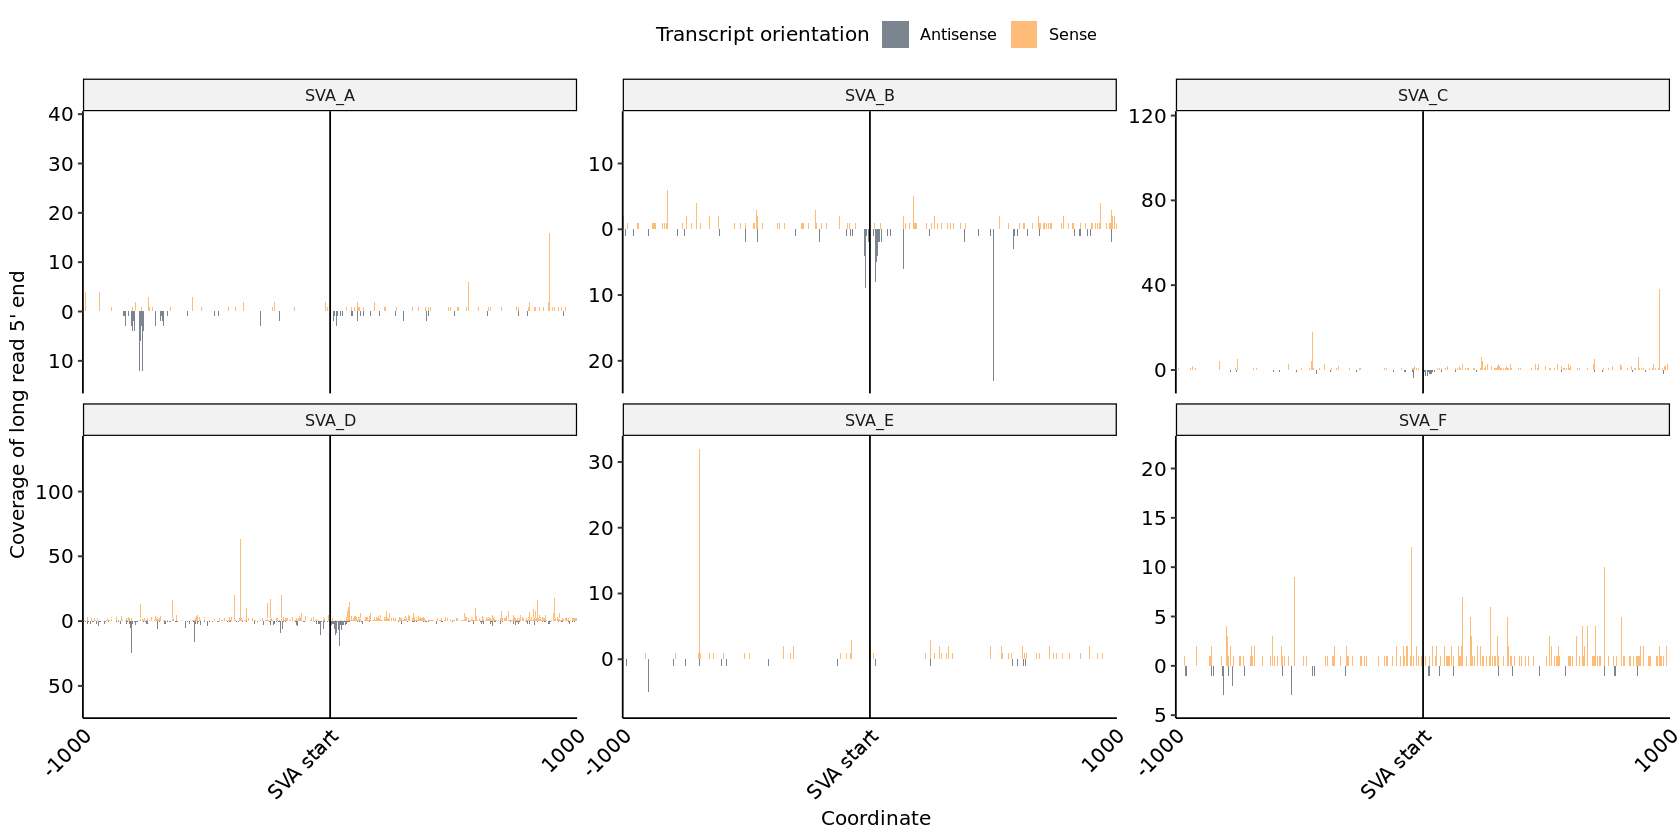

In [15]:
options(repr.plot.width = 14, repr.plot.height = 7)
plots_five_prime_cov_by_sva

Fig. 1B. 5' profile (read start coverage) for separate SVAs across multiple samples. Orange and blue bars depict the coverage of the positive and negative strands, respectively. A solid black line indicates the SVA start position, and a dashed black line indicates the regular end of the hexamer in DFAM SVA consensus sequences (72 nt after start).

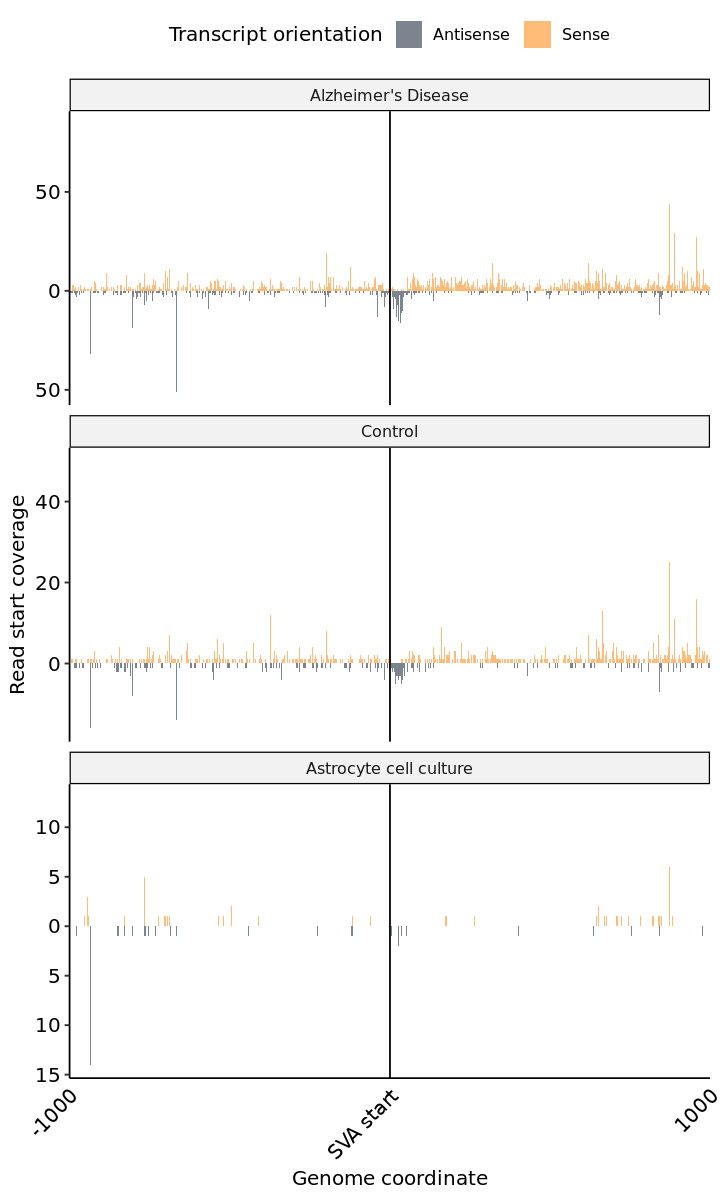

In [16]:
# split by sample source
options(repr.plot.width = 6, repr.plot.height = 10)
plots_five_prime_cov_by_sample

Fig. 1C. 5' profile (read start coverage) for all SVAs split by sample source. Orange and blue bars depict the coverage of the positive and negative strands, respectively. A solid black line indicates the SVA start position, and a dashed black line indicates the regular end of the hexamer in DFAM SVA consensus sequences (72 nt after start). The number of samples is five, four, and, two (Alzheimer's Disease, Control, and Astrocyte cell culture, respectively).

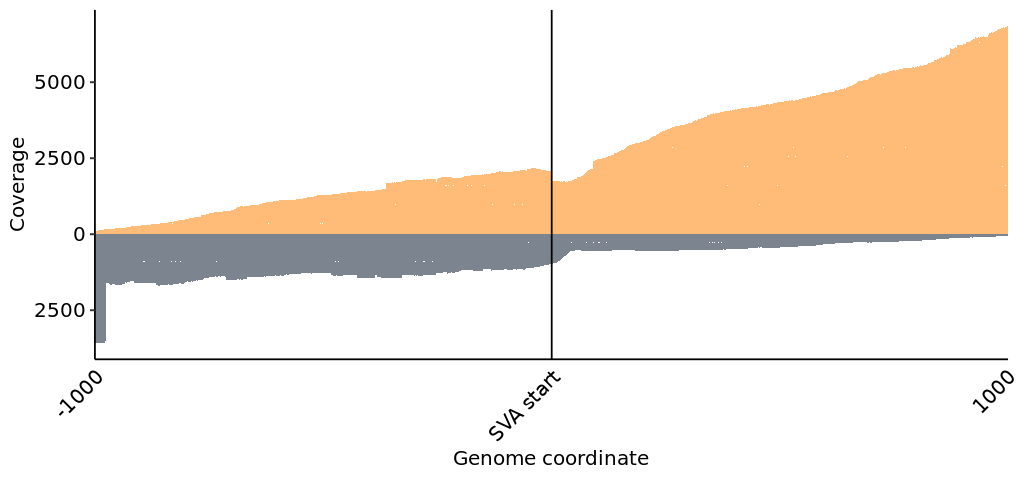

In [17]:
options(repr.plot.width = 8.49, repr.plot.height = 4)
# regular coverage
plots_coverage_all

Fig. 2A. Coverage of reads starting within the [-1000, 1000] interval (single nucleotide resolution read depth) for all SVAs across multiple samples. Orange and blue bars depict the coverage of the positive and negative strands, respectively. A solid black line indicates the SVA start position, and a dashed black line indicates the regular end of the hexamer in DFAM SVA consensus sequences (72 nt after start).

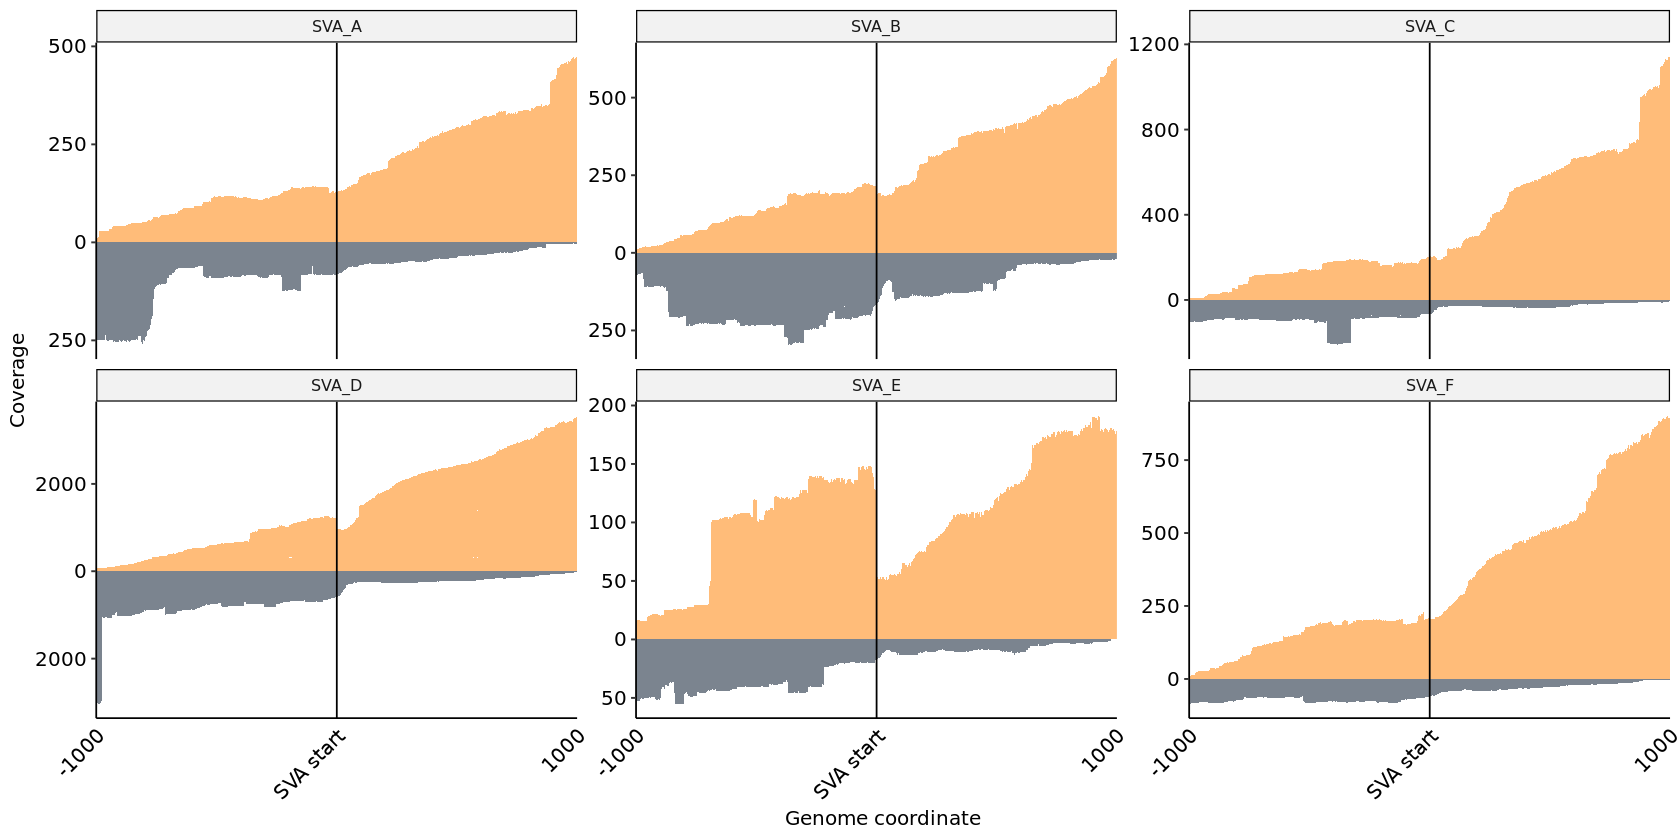

In [18]:
options(repr.plot.width = 14, repr.plot.height = 7)
plots_coverage_by_sva

Fig. 2B. Coverage of reads starting within the [-1000, 1000] interval (single nucleotide resolution read depth) for separate SVAs across multiple samples. Orange and blue bars depict the coverage of the positive and negative strands, respectively. A solid black line indicates the SVA start position, and a dashed black line indicates the regular end of the hexamer in DFAM SVA consensus sequences (72 nt after start).

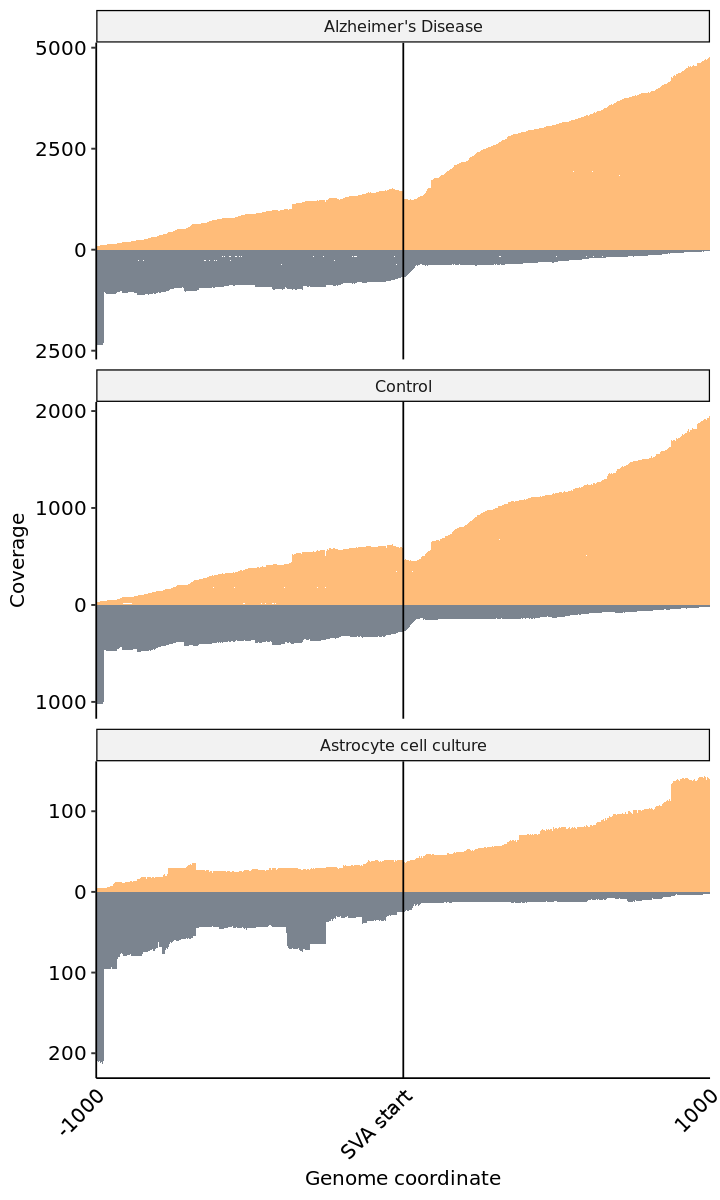

In [19]:
# split by sample source
options(repr.plot.width = 6, repr.plot.height = 10)
plots_coverage_by_sample

Fig. 2C. Coverage of reads starting within the [-1000, 1000] interval (single nucleotide resolution read depth) for all SVAs split by sample source. Orange and blue bars depict the coverage of the positive and negative strands, respectively. A solid black line indicates the SVA start position, and a dashed black line indicates the regular end of the hexamer in DFAM SVA consensus sequences (72 nt after start). The number of samples is five, four, and, two (Alzheimer's Disease, Control, and Astrocyte cell culture, respectively).

## SVAs contributing to counts

Not all the SVA loci contribute to the counts above. For that reason, I will inquire how many of them are contributing with reads **within** the SVA region (coordinate >= 1). This approach disregard samples, so it looks for SVAs producing reads in any of them.

### 5' profile

Number of inspected SVAs:

In [20]:
sva_bed %>% dim() %>% .[1]

[1] 2154

Number of SVAs contributing to 5' prime profile plots (sense or antisense):

In [21]:
insights$five_prime_profile$counts_per_sva %>% dim() %>% .[1]

[1] 779

Below, we see how the 5' profile looks like for the positive (A) and negative (B) strands (ordered by average of counts; index order may differ between panels).

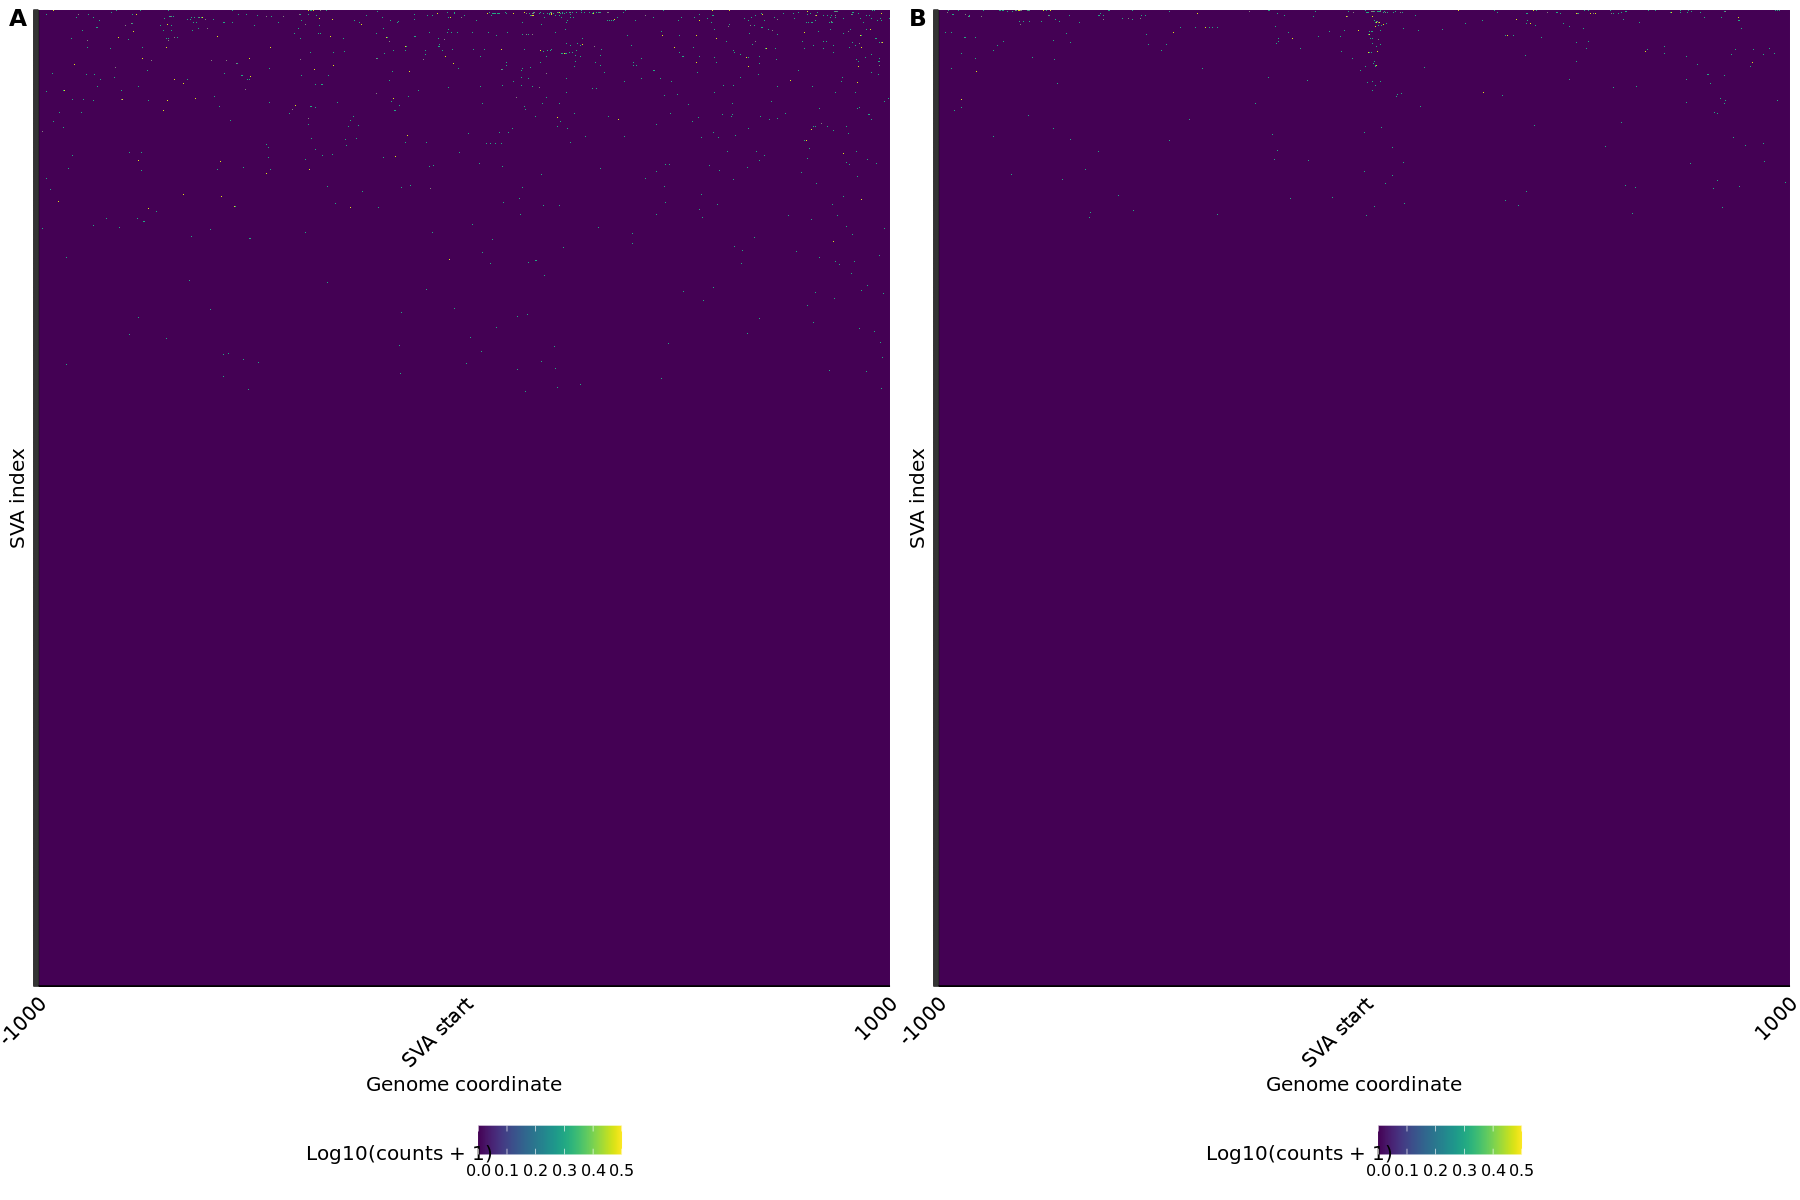

In [22]:
options(repr.plot.height = 10, repr.plot.width = 15)
plots_five_prime_cov_tiles_panel

### Coverage

Number of SVAs contributing to coverage plots (sense or antisense):

In [23]:
insights$coverage$counts_per_sva %>% dim() %>% .[1]

[1] 955

Below, we see how the coverage looks like for the positive (A) and negative (B) strands (ordered by average of counts; index order may differ between panels)).

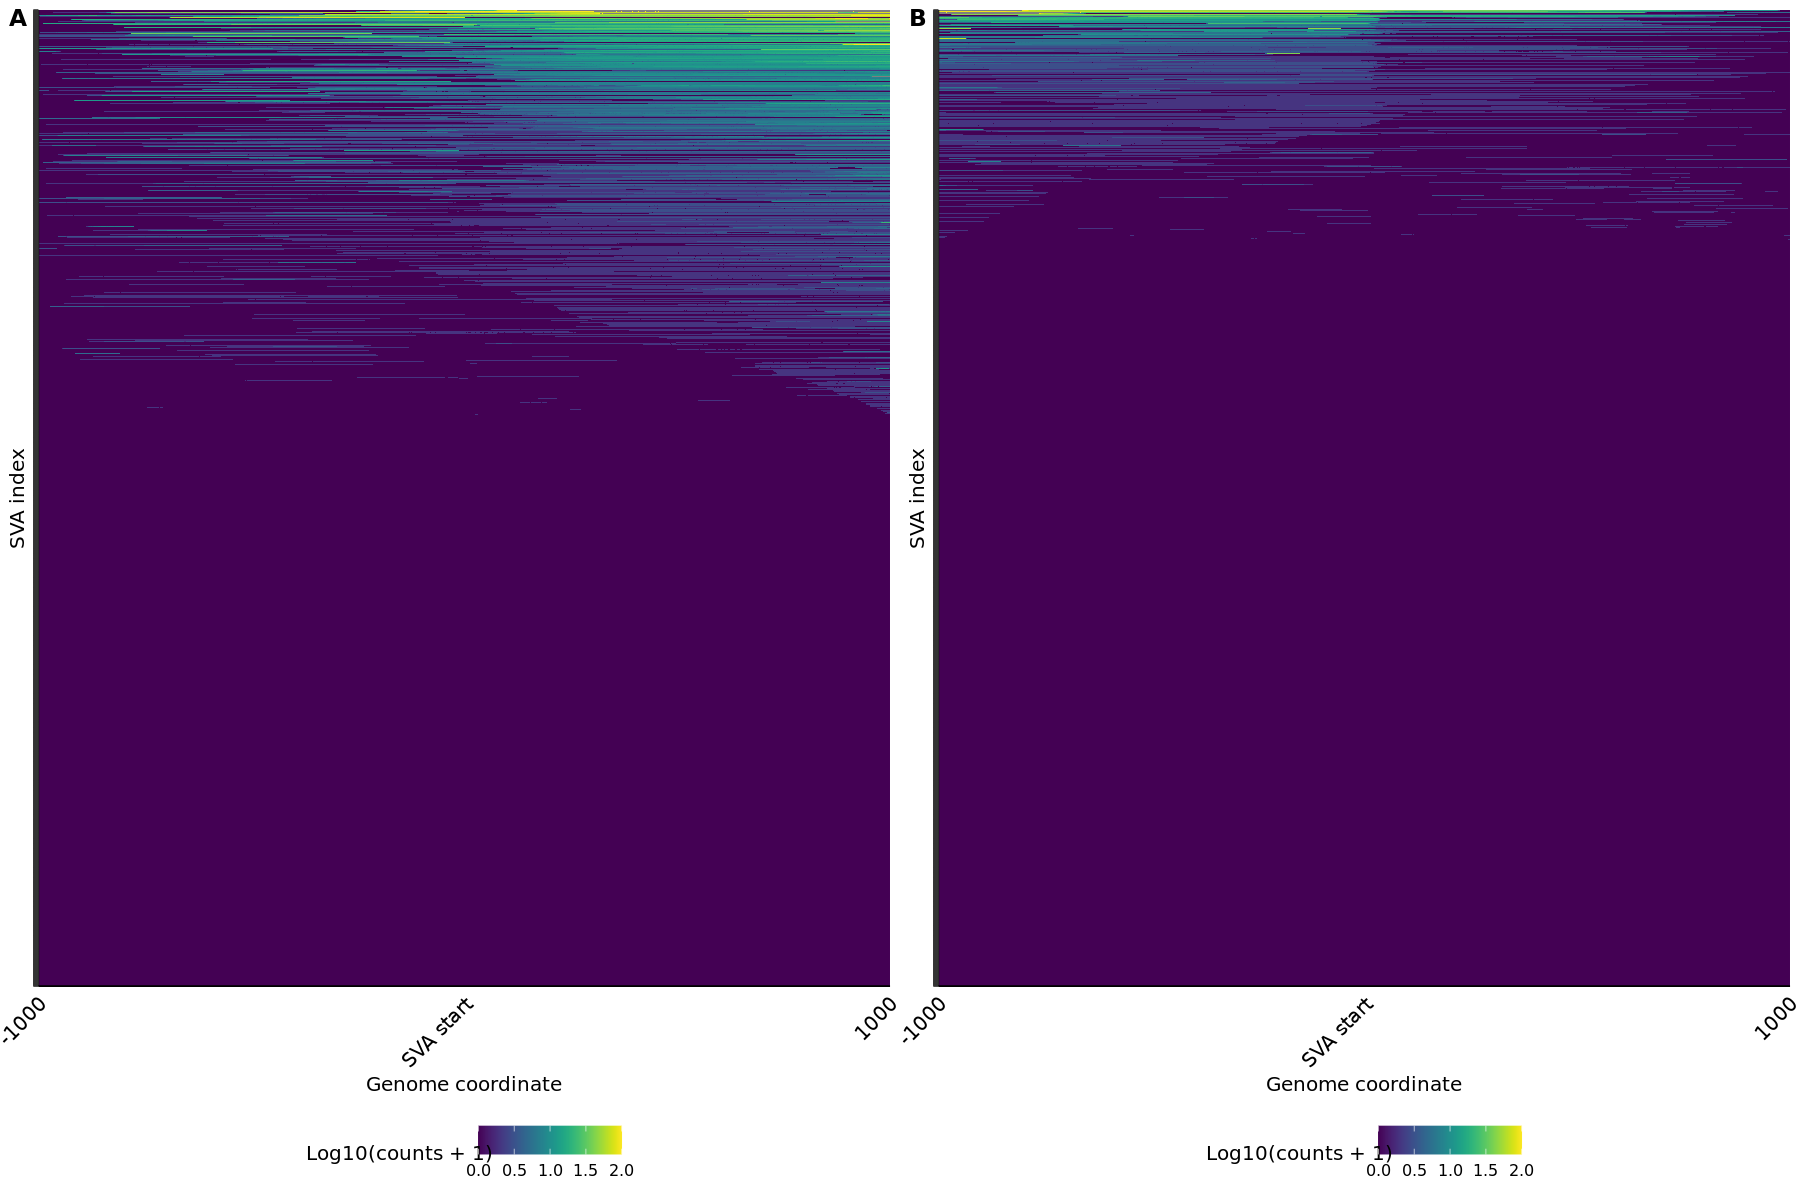

In [24]:
options(repr.plot.height = 10, repr.plot.width = 15)
plots_coverage_tiles_panel

# Session info

In [25]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Arch Linux

Matrix products: default
BLAS/LAPACK: /ceph/users/alorenzetti/conda/shared_envs/sva_expression_brain_longr_qvm2_env_r/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggbeeswarm_0.6.0     BSgenome_1.62.0      rtracklayer_1.54.0  
 [4] GenomicRanges_1.46.1 Biostrings_2.62.0    GenomeInfoDb_1.30.0 
 [7] XVector_0.34.0       IRanges_2.28.0       S4Vectors_0.32.4    
[10] BiocGenerics_0.40.0  viridis_0.6.2        vir